--- System Configuration ---
Target Operation SNR: 18.0 dB
Training Robustness SNR: 13.0 dB (Noise Std: 0.2239)
----------------------------
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3187 - loss: 2.0394 - learning_rate: 0.0010
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5376 - loss: 1.1262 - learning_rate: 0.0010
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5881 - loss: 0.9484 - learning_rate: 0.0010
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6003 - loss: 0.9142 - learning_rate: 0.0010
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6155 - loss: 0.8891 - learning_rate: 0.0010
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6239 - loss: 0.8725 - learning_rate: 0.0010
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6532 - loss: 0.8347 - learning_rate: 0.0010
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6932 - loss: 0.7673 - learning_

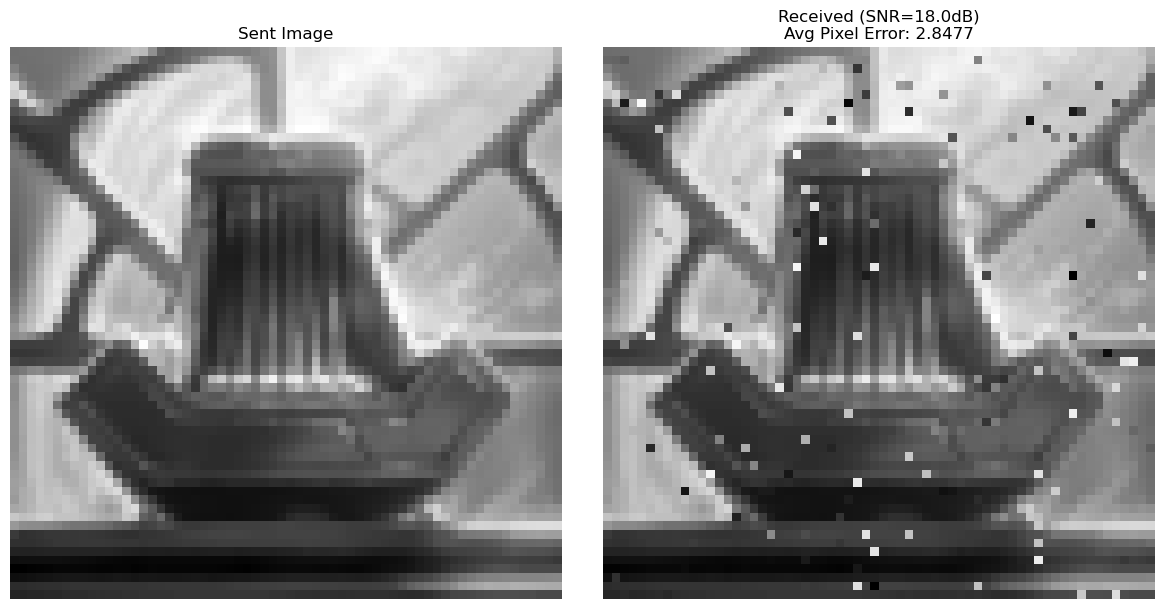

In [95]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import PIL.Image as Image

# --- 1. Real-World System Config ---
M = 16            # 16-QAM equivalent (Standard modulation)
n_channel = 2     # I/Q Channel (Real and Imaginary parts)

# Real-world target: Good connection (LTE/WiFi strong signal)
TEST_SNR_DB = 18.0 

# We train at a LOWER SNR to force the model to be robust
# (Training at 13dB makes it bulletproof at 18dB)
TRAIN_SNR_DB = 13.0 

def non_linear_channel(x):
    # Simulates Power Amplifier saturation
    return tf.tanh(x)

# Function to convert SNR dB to Noise StdDev
def get_noise_std(snr_db):
    snr_linear = 10**(snr_db / 10.0)
    # 1/SNR because signal power is normalized to ~1.0
    return np.sqrt(1.0 / snr_linear)

# --- 2. Optimized Model Construction ---
input_signal = layers.Input(shape=(M,))

# --- ENCODER ---
# 3 Layers provides enough complexity to "warp" the space around the non-linearity
x = layers.Dense(128, activation='relu')(input_signal)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(n_channel, activation='linear')(x)

# Constraint: Unit Average Power (Real transmitters have power limits)
encoded = layers.BatchNormalization(center=False, scale=False)(x)

# --- CHANNEL SIMULATION ---
# 1. Distortion (PA Non-linearity)
distorted = layers.Lambda(non_linear_channel)(encoded)

# 2. Additive White Gaussian Noise (AWGN)
# We inject the calculated TRAIN noise here
train_noise_std = get_noise_std(TRAIN_SNR_DB)
channel_out = layers.GaussianNoise(stddev=train_noise_std)(distorted)

# --- DECODER ---
# Decoder needs slightly more capacity to "undo" the non-linear damage
dec_input = layers.Input(shape=(n_channel,))
dec_l1 = layers.Dense(64, activation='relu')
dec_l2 = layers.Dense(128, activation='relu')
dec_out = layers.Dense(M, activation='softmax') # Probability of each symbol

# Connect for Training
decoded = dec_out(dec_l2(dec_l1(channel_out)))

model = keras.Model(input_signal, decoded)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- 3. Optimized Training Loop ---
print(f"--- System Configuration ---")
print(f"Target Operation SNR: {TEST_SNR_DB} dB")
print(f"Training Robustness SNR: {TRAIN_SNR_DB} dB (Noise Std: {train_noise_std:.4f})")
print("----------------------------")

# Generate massive random training data to cover all symbol transitions
N_train = 80000 
train_labels = np.random.randint(0, M, N_train)
train_onehot = tf.keras.utils.to_categorical(train_labels, M)

# Learning Rate Scheduler:
# Starts fast, then slows down drastically to "settle" the constellation points
lr_sch = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-5,
    verbose=1
)

model.fit(train_onehot, train_onehot, 
          epochs=100,            # Sufficient for convergence
          batch_size=1024,      # Large batch = stable gradient
          callbacks=[lr_sch], 
          verbose=1)

# --- Extract Inference Models ---
encoder_func = keras.Model(input_signal, encoded)
# Re-build decoder model from trained layers
decoder_func = keras.Model(dec_input, dec_out(dec_l2(dec_l1(dec_input))))

# --- 4. Transmission Demo ---
def transmit_real_world(image_path='Chair.png', snr_db=TEST_SNR_DB):
    # Load Image
    try:
        img = Image.open(image_path).convert('L')
    except:
        print("Image not found, generating pattern.")
        img = Image.fromarray(np.uint8(np.indices((64,64))[0] * 4))
    
    img = img.resize((64, 64))
    img_data = np.array(img)
    
    # --- Source Coding ---
    # Convert pixel (0-255) to two 4-bit symbols (0-15)
    tx_symbols = []
    for p in img_data.flatten():
        tx_symbols.extend([(p >> 4) & 0x0F, p & 0x0F])
    tx_symbols = np.array(tx_symbols)
    
    # --- Neural Encoding ---
    tx_onehot = tf.keras.utils.to_categorical(tx_symbols, M)
    tx_coords = encoder_func.predict(tx_onehot, verbose=0, batch_size=4096)
    
    # --- Real Channel ---
    # 1. Power Amplifier Saturation
    tx_distorted = np.tanh(tx_coords)
    
    # 2. Channel Noise (At the TEST SNR)
    test_noise_std = get_noise_std(snr_db)
    noise = np.random.normal(0, test_noise_std, tx_coords.shape)
    rx_coords = tx_distorted + noise
    
    # --- Neural Decoding ---
    pred_probs = decoder_func.predict(rx_coords, verbose=0, batch_size=4096)
    rx_symbols = np.argmax(pred_probs, axis=1)
    
    # --- Reconstruction ---
    rx_pixels = []
    errors = 0
    for i in range(0, len(rx_symbols), 2):
        # Recombine 4-bit symbols into 8-bit pixel
        pixel_val = (rx_symbols[i] << 4) | rx_symbols[i+1]
        rx_pixels.append(pixel_val)
        
        # Count Symbol Errors (just for metrics)
        if rx_symbols[i] != tx_symbols[i]: errors += 1
        if rx_symbols[i+1] != tx_symbols[i+1]: errors += 1

    received_raw = np.array(rx_pixels).reshape(64,64).astype(np.uint8)
    
    ser = errors / len(tx_symbols)
    print(f"\nTransmission Stats:")
    print(f"SNR: {snr_db} dB")
    print(f"Symbol Error Rate (SER): {ser:.5f}")
    
    return img_data, received_raw

# Run transmission at realistic 18dB
orig, raw = transmit_real_world(snr_db=TEST_SNR_DB)

# Calculate Pixel Difference
diff = np.abs(orig.astype(int) - raw.astype(int))
avg_diff = np.mean(diff)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig, cmap='gray')
plt.title("Sent Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(raw, cmap='gray')
plt.title(f"Received (SNR={TEST_SNR_DB}dB)\nAvg Pixel Error: {avg_diff:.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()